
# Student Dropout Risk Prediction — Kaggle Dataset (Binary Classification)

**Project:** Student Dropout Risk Prediction  
**Dataset:** Kaggle – Students Dropout and Academic Success (`Target` = Dropout / Enrolled / Graduate)  
**Task:** Binary classification – predict whether a student will **Drop out (1)** or **Not drop out (0)**.

This notebook does:

1. Load the Kaggle dataset  
2. Create a binary target: `Dropout = 1`, `Enrolled/Graduate = 0`  
3. Split into train and test sets  
4. Preprocess numeric features (impute + scale)  
5. Train three models: Logistic Regression, Random Forest, XGBoost  
6. Evaluate metrics (Accuracy, Precision, Recall, F1, ROC-AUC)  
7. Plot ROC curve for the best model  
8. Plot feature importance for tree-based model  
9. Save the best model pipeline as a `.joblib` file


## 1. Setup and Imports

In [ ]:

# !pip install numpy pandas scikit-learn imbalanced-learn xgboost matplotlib seaborn joblib


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", 200)
sns.set()


## 2. Load Kaggle Dataset

In [ ]:


CSV_PATH = "dataset.csv" 

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV file not found at: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
df.head()


Shape: (4424, 35)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 3. Target Encoding (Binary: Dropout vs Not Dropout)

In [3]:

print("Unique values in Target:", df["Target"].unique())
print("\nValue counts:")
print(df["Target"].value_counts())

# Binary target: Dropout = 1, others = 0
y = (df["Target"].astype(str).str.strip() == "Dropout").astype(int)
X = df.drop(columns=["Target"])

print("\nClass balance (0 = Not Dropout, 1 = Dropout):")
print(y.value_counts(normalize=True))

X.head()


Unique values in Target: ['Dropout' 'Graduate' 'Enrolled']

Value counts:
Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Class balance (0 = Not Dropout, 1 = Dropout):
Target
0    0.678797
1    0.321203
Name: proportion, dtype: float64


,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79


## 4. Train/Test Split

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((3539, 34), (885, 34))

## 5. Preprocessing (Numeric Features Only)

In [ ]:


num_cols = X.columns.tolist()
print("Number of numeric features:", len(num_cols))

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_tf, num_cols)
])


Number of numeric features: 34


## 6. Define Models and Training Function

In [6]:

def train_and_evaluate_models(X_train, X_test, y_train, y_test, use_smote=True, random_state=42):
    models = {
        "LogisticRegression": LogisticRegression(max_iter=300, class_weight="balanced"),
        "RandomForest": RandomForestClassifier(
            n_estimators=300,
            random_state=random_state,
            class_weight="balanced"
        ),
        "XGBoost": XGBClassifier(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            random_state=random_state,
        ),
    }

    results = {}

    for name, clf in models.items():
        if use_smote:
            pipe = ImbPipeline(steps=[
                ("pre", preprocessor),
                ("smote", SMOTE(random_state=random_state)),
                ("clf", clf)
            ])
        else:
            pipe = Pipeline(steps=[
                ("pre", preprocessor),
                ("clf", clf)
            ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps["clf"], "predict_proba") else None

        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred, zero_division=0),
            "f1": f1_score(y_test, y_pred, zero_division=0),
        }
        if y_proba is not None:
            try:
                metrics["roc_auc"] = roc_auc_score(y_test, y_proba)
            except Exception:
                metrics["roc_auc"] = np.nan

        results[name] = {
            "pipeline": pipe,
            "metrics": metrics,
            "y_test": y_test,
            "y_pred": y_pred,
            "y_proba": y_proba,
        }

    return results


### 6.1 Train All Models

In [7]:

results = train_and_evaluate_models(X_train, X_test, y_train, y_test, use_smote=True)

for model_name, out in results.items():
    print(f"\n=== {model_name} ===")
    print("Metrics:", out["metrics"])
    print("\nClassification Report:")
    print(classification_report(out["y_test"], out["y_pred"], digits=3, zero_division=0))
    print("Confusion matrix:\n", confusion_matrix(out["y_test"], out["y_pred"]))



=== LogisticRegression ===
Metrics: {'accuracy': 0.8745762711864407, 'precision': 0.7836065573770492, 'recall': 0.8415492957746479, 'f1': 0.8115449915110357, 'roc_auc': 0.9278549834782404}

Classification Report:
              precision    recall  f1-score   support

           0      0.922     0.890     0.906       601
           1      0.784     0.842     0.812       284

    accuracy                          0.875       885
   macro avg      0.853     0.866     0.859       885
weighted avg      0.878     0.875     0.876       885

Confusion matrix:
 [[535  66]
 [ 45 239]]

=== RandomForest ===
Metrics: {'accuracy': 0.8870056497175142, 'precision': 0.8484848484848485, 'recall': 0.7887323943661971, 'f1': 0.8175182481751825, 'roc_auc': 0.9322637154039044}

Classification Report:
              precision    recall  f1-score   support

           0      0.903     0.933     0.918       601
           1      0.848     0.789     0.818       284

    accuracy                          0.887  

## 7. ROC Curve for Best Model

Best model (by ROC-AUC): XGBoost
Metrics: {'accuracy': 0.8813559322033898, 'precision': 0.8352059925093633, 'recall': 0.7852112676056338, 'f1': 0.809437386569873, 'roc_auc': 0.9331396030090693}


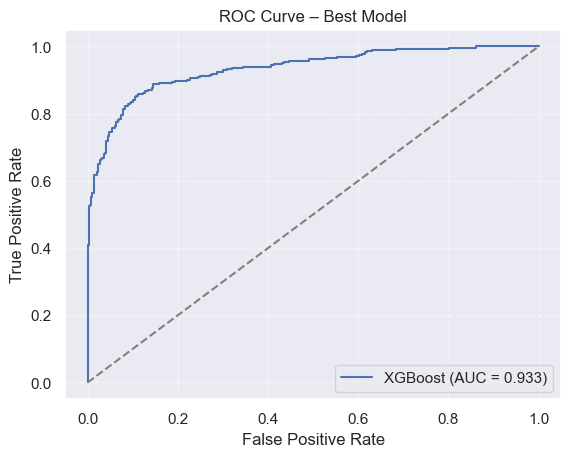

In [8]:

def get_best_model(results_dict, metric="roc_auc"):
    best_name, best_score = None, -1
    for name, out in results_dict.items():
        score = out["metrics"].get(metric, -1)
        if score is not None and score > best_score:
            best_name, best_score = name, score
    return best_name, results_dict[best_name]

best_name, best_out = get_best_model(results, metric="roc_auc")
print("Best model (by ROC-AUC):", best_name)
print("Metrics:", best_out["metrics"])

if best_out["y_proba"] is not None:
    fpr, tpr, _ = roc_curve(best_out["y_test"], best_out["y_proba"])
    auc_val = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{best_name} (AUC = {auc_val:.3f})")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve – Best Model")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
else:
    print("Best model does not provide probability outputs; cannot plot ROC.")


## 8. Feature Importance (Tree-Based Best Model)

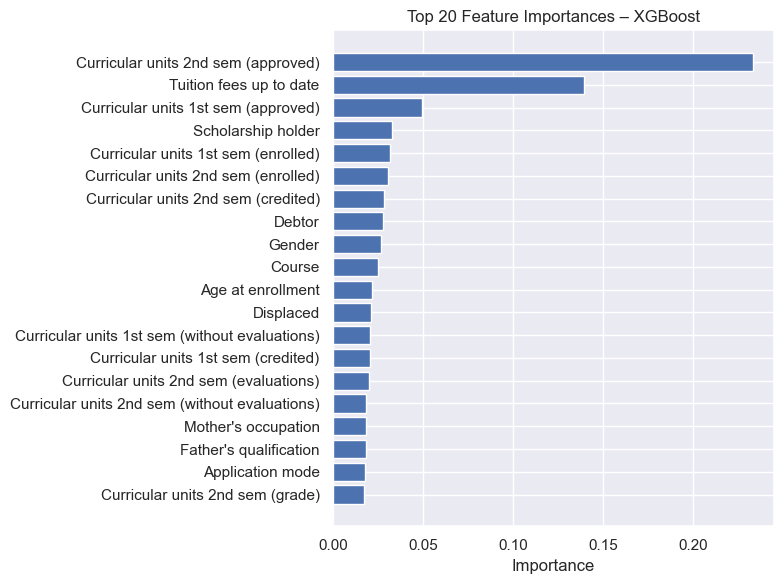

In [ ]:

pipe = best_out["pipeline"]
clf = pipe.named_steps["clf"]

if hasattr(clf, "feature_importances_"):
    
    feature_names = num_cols
    importances = clf.feature_importances_
    idx = np.argsort(importances)[::-1][:20]

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(idx)), importances[idx][::-1])
    plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
    plt.xlabel("Importance")
    plt.title(f"Top 20 Feature Importances – {best_name}")
    plt.tight_layout()
    plt.show()
else:
    print("Best model has no feature_importances_ attribute. Try using RandomForest or XGBoost as best model.")


## 9. Save Best Model Pipeline

In [10]:

os.makedirs("models", exist_ok=True)
model_path = f"models/best_kaggle_{best_name}.joblib"
joblib.dump(best_out["pipeline"], model_path)
print("Saved best model pipeline to:", model_path)


Saved best model pipeline to: models/best_kaggle_XGBoost.joblib
